# Combine RMSE Run Scores

In [1]:
import os
from pathlib import Path
import pandas as pd

# Get the notebook's directory path
notebook_dir = Path(os.getcwd())

# Get the project root directory (2 levels up from notebook)
project_root = notebook_dir.parent.parent
results_dir = project_root / "results/processed"
print(results_dir)

# Use pathlib's rglob to recursively find all csv files
csv_files = list(results_dir.rglob("*.csv"))
print(f"Found {len(csv_files)} CSV files")

sample_df = pd.read_csv(csv_files[0])

sample_df

/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/results/processed
Found 34 CSV files


,validation_id,model_id,runtime_secs,MeanSquaredError_mean,MeanSquaredError_std
0,p02,ZeroShotTinyTimeMixerForecaster,7.877197,2.122298,0.673537
1,p03,ZeroShotTinyTimeMixerForecaster,4.828758,3.213307,2.069466
2,p04,ZeroShotTinyTimeMixerForecaster,0.431917,1.840493,0.538041
3,p10,ZeroShotTinyTimeMixerForecaster,0.442564,1.479329,0.589133
4,p11,ZeroShotTinyTimeMixerForecaster,0.432557,2.542815,1.102587
5,p12,ZeroShotTinyTimeMixerForecaster,0.924047,2.543586,1.827144


In [2]:
def parse_model_id(df):
    # Split on hyphens and create a dictionary of key-value pairs
    def parse_id(model_id):
        parts = model_id.split("-")
        # Initialize dictionary with default values
        result = {
            "model_type": parts[0],
            "model_details": " ".join(parts[1:]),
        }

        return result

    # Apply parsing to each model_id
    parsed = df["model_id"].apply(parse_id).apply(pd.Series)

    # Combine original dataframe with parsed columns
    return pd.concat([df, parsed], axis=1)


parse_model_id(sample_df)

,validation_id,model_id,runtime_secs,MeanSquaredError_mean,MeanSquaredError_std,model_type,model_details
0,p02,ZeroShotTinyTimeMixerForecaster,7.877197,2.122298,0.673537,ZeroShotTinyTimeMixerForecaster,
1,p03,ZeroShotTinyTimeMixerForecaster,4.828758,3.213307,2.069466,ZeroShotTinyTimeMixerForecaster,
2,p04,ZeroShotTinyTimeMixerForecaster,0.431917,1.840493,0.538041,ZeroShotTinyTimeMixerForecaster,
3,p10,ZeroShotTinyTimeMixerForecaster,0.442564,1.479329,0.589133,ZeroShotTinyTimeMixerForecaster,
4,p11,ZeroShotTinyTimeMixerForecaster,0.432557,2.542815,1.102587,ZeroShotTinyTimeMixerForecaster,
5,p12,ZeroShotTinyTimeMixerForecaster,0.924047,2.543586,1.827144,ZeroShotTinyTimeMixerForecaster,


In [3]:
all_results = parse_model_id(pd.read_csv(csv_files[0]))
all_results = all_results.drop(all_results.index)

for file in csv_files:
    full_path = os.path.abspath(file)
    model_family = os.path.basename(os.path.dirname(os.path.dirname(full_path)))
    filename = os.path.splitext(os.path.basename(file))[0]

    # print(f"\nProcessing: {full_path}")
    print(f"Time: {filename[-5:]}, Model Family: {model_family}, Filename: {filename}")

    df = pd.read_csv(file)
    df["time_delta"] = filename[-5:]
    df["model_family"] = model_family
    df["full_path"] = full_path
    all_results = pd.concat([all_results, parse_model_id(df)], ignore_index=True)
    # print(f"Added: {filename}")

# After the loop, reorder columns in the final combined DataFrame
order_columns = [
    "time_delta",
    "validation_id",
    "model_family",
    "model_type",
    "model_details",
    "model_id",
]
remaining_cols = [col for col in all_results.columns if col not in order_columns]
all_results = all_results[order_columns + remaining_cols]

Time: 05min, Model Family: foundation, Filename: 2025-02-23_00-35-12_ttm_05min
Time: 05min, Model Family: foundation, Filename: 2025-02-23_13-30-03_hftransformers_autoformer_05min
Time: 05min, Model Family: foundation, Filename: 2025-02-23_00-30-32_chronos_small_05min
Time: 05min, Model Family: foundation, Filename: 2025-02-23_15-38-42_hftransformers_informer_05min
Time: 05min, Model Family: foundation, Filename: 2025-02-23_16-25-05_hftransformers_ts_transformer_05min
Time: 05min, Model Family: foundation, Filename: 2025-02-23_00-32-31_chronos_base_05min
Time: 15min, Model Family: foundation, Filename: 2025-02-23_12-18-22_hftransformers_ts_transformer_15min
Time: 15min, Model Family: foundation, Filename: 2025-02-23_00-52-51_hftransformers_autoformer_15min
Time: 15min, Model Family: foundation, Filename: 2025-02-23_00-31-31_chronos_small_15min
Time: 15min, Model Family: foundation, Filename: 2025-02-23_00-35-45_ttm_15min
Time: 15min, Model Family: foundation, Filename: 2025-02-23_00-33

In [4]:
all_results.iloc[-1]["full_path"]

'/home/cjrisi/Projects/diabetes/nocturnal-hypo-gly-prob-forecast/results/processed/pinball/naive/15mins/2025-02-27_21-25-14_0_naive_15min.csv'

In [5]:
group_structure = ["time_delta", "validation_id", "model_family", "model_type"]
best_results_rmse = all_results.groupby(group_structure).agg(
    # Median=("MeanSquaredError_mean", "median"),
    Best=("MeanSquaredError_mean", "min"),
)

best_results_pinball = all_results.groupby(group_structure).agg(
    # Median=("PinballLoss_mean", "median"),
    Best=("PinballLoss_mean", "min"),
)

In [6]:
best_results_rmse

Best
time_delta validation_id model_family model_type                               
05min      p02           arch         ARCH                             2.194514
                         arma         AutoARIMA                        1.940629
                                      AutoREG                               NaN
                                      VARReduce                        2.011910
                         exponential  AutoETS                          3.620625
...                                                                         ...
15min      p06           foundation   ChronosForecaster                2.757905
                                      HFTransformersForecaster         4.197128
                                      ZeroShotTinyTimeMixerForecaster  3.115242
                         naive        NaiveForecaster                  3.281241
                         structural   ARDL                                  NaN

[117 rows x 1 columns]

In [7]:
best_results_pinball

Best
time_delta validation_id model_family model_type                               
05min      p02           arch         ARCH                                  NaN
                         arma         AutoARIMA                        0.250986
                                      AutoREG                               NaN
                                      VARReduce                             NaN
                         exponential  AutoETS                          0.476779
...                                                                         ...
15min      p06           foundation   ChronosForecaster                     NaN
                                      HFTransformersForecaster              NaN
                                      ZeroShotTinyTimeMixerForecaster       NaN
                         naive        NaiveForecaster                  0.397919
                         structural   ARDL                                  NaN

[117 rows x 1 columns]

In [8]:
best_results_unstacked_rmse = best_results_rmse.unstack(["model_family", "model_type"])
best_results_unstacked_rmse

Best                                            \
model_family                  arch      arma                     exponential   
model_type                    ARCH AutoARIMA   AutoREG VARReduce     AutoETS   
time_delta validation_id                                                       
05min      p02            2.194514  1.940629       NaN  2.011910    3.620625   
           p03            2.321361  2.527653       NaN  2.550394    3.479550   
           p04            1.567769  1.869230       NaN  1.679178    2.314285   
           p10            1.391561  1.350220       NaN  1.319039    1.973768   
           p11            2.335492  3.171313       NaN  2.344692    2.952654   
           p12            2.020626  1.949389       NaN  2.128375    2.551135   
15min      p01            3.469633  3.631367  3.024733  3.545806    4.459680   
           p05            2.094690  2.600266       NaN  2.395073    2.425653   
           p06            2.887047  2.728342       NaN  2.934976    4.507109   

                                                                    \
model_family                                                         
model_type               StatsForecastAutoCES StatsForecastAutoETS   
time_delta validation_id                                             
05min      p02                       2.934229             3.042978   
           p03                       3.467259             3.447532   
           p04                       2.177399             2.238956   
           p10                       1.782622             1.734136   
           p11                       2.876312             2.801125   
           p12                       2.632567             2.655361   
15min      p01                       4.686850             4.195522   
           p05                       2.320795             2.312781   
           p06                       3.390976             3.281250   

                                                                   \
model_family                                           foundation   
model_type               StatsForecastAutoTheta ChronosForecaster   
time_delta validation_id                                            
05min      p02                         3.041694          2.211347   
           p03                         3.447707          2.943977   
           p04                         2.238767          1.839182   
           p10                         1.733843          1.435374   
           p11                         2.802769          2.672459   
           p12                         2.658062          2.444096   
15min      p01                         4.192593          3.728067   
           p05                         2.313530          2.280566   
           p06                         3.286409          2.757905   

                                                   \
model_family                                        
model_type               HFTransformersForecaster   
time_delta validation_id                            
05min      p02                           2.865613   
           p03                           2.806601   
           p04                           2.503176   
           p10                           1.554336   
           p11                           3.079310   
           p12                           3.663847   
15min      p01                           4.576481   
           p05                           2.996683   
           p06                           4.197128   

                                                                          \
model_family                                                       naive   
model_type               ZeroShotTinyTimeMixerForecaster NaiveForecaster   
time_delta validation_id                                                   
05min      p02                                  2.122298        2.355567   
           p03                                  3.213307        2.796923   
           p04                    

In [9]:
best_results_unstacked_pinball = best_results_pinball.unstack(
    ["model_family", "model_type"]
)
best_results_unstacked_pinball

Best                                          \
model_family             arch      arma                   exponential   
model_type               ARCH AutoARIMA AutoREG VARReduce     AutoETS   
time_delta validation_id                                                
05min      p02            NaN  0.250986     NaN       NaN    0.476779   
           p03            NaN  0.305181     NaN       NaN    0.483686   
           p04            NaN  0.196786     NaN       NaN    0.524332   
           p10            NaN  0.203004     NaN       NaN    0.373254   
           p11            NaN  0.415240     NaN       NaN    0.448070   
           p12            NaN  0.256296     NaN       NaN    0.379762   
15min      p01            NaN  0.428167     NaN       NaN    0.893845   
           p05            NaN  0.232785     NaN       NaN    0.632867   
           p06            NaN  0.389101     NaN       NaN    0.655476   

                                                                    \
model_family                                                         
model_type               StatsForecastAutoCES StatsForecastAutoETS   
time_delta validation_id                                             
05min      p02                       0.995572             0.354829   
           p03                       1.261451             0.645074   
           p04                       0.659106             0.260030   
           p10                       0.521099             0.206731   
           p11                       0.913444             0.361564   
           p12                       0.873299             0.500948   
15min      p01                       1.431632             0.582371   
           p05                       0.542227             0.258574   
           p06                       0.941481             0.321016   

                                                                   \
model_family                                           foundation   
model_type               StatsForecastAutoTheta ChronosForecaster   
time_delta validation_id                                            
05min      p02                         0.393450               NaN   
           p03                         0.659228               NaN   
           p04                         0.254548               NaN   
           p10                         0.227142               NaN   
           p11                         0.373693               NaN   
           p12                         0.502996               NaN   
15min      p01                         0.607090               NaN   
           p05                         0.266842               NaN   
           p06                         0.405048               NaN   

                                                   \
model_family                                        
model_type               HFTransformersForecaster   
time_delta validation_id                            
05min      p02                                NaN   
           p03                                NaN   
           p04                                NaN   
           p10                                NaN   
           p11                                NaN   
           p12                                NaN   
15min      p01                                NaN   
           p05                                NaN   
           p06                                NaN   

                                                                          \
model_family                                                       naive   
model_type               ZeroShotTinyTimeMixerForecaster NaiveForecaster   
time_delta validation_id                                                   
05min      p02                                       NaN        0.252837   
           p03                                       NaN        0.347352   
           p04                                       NaN        0.208814   
           p10                              

In [19]:
def highlight_scores(row):
    # Create masks
    min_mask = row == row.min()

    # Get NaiveForecaster values for each model family
    naive_values = row.loc[
        row.index.get_level_values("model_type") == "NaiveForecaster"
    ]

    # Compare each value with corresponding NaiveForecaster value
    naive_mask = row.apply(lambda x: any(x > naive_values))

    # Initialize style arrays
    bold = ["font-weight: bold; color: skyblue" if v else "" for v in min_mask]
    font_color = ["color: #FFB366" if v else "" for v in naive_mask]

    # Combine styles
    return [f"{b}; {bg}" if (b or bg) else "" for b, bg in zip(bold, font_color)]


# Round the DataFrames first
rounded_rmse = best_results_unstacked_rmse.round(3)
rounded_pinball = best_results_unstacked_pinball.round(3)

# Apply styling to rounded DataFrames with explicit number formatting
styled_results_rmse = rounded_rmse.style.apply(highlight_scores, axis=1).format(
    "{:.3f}"
)  # Force 3 decimal places

styled_results_pinball = rounded_pinball.style.apply(highlight_scores, axis=1).format(
    "{:.3f}"
)  # Force 3 decimal places

display(styled_results_rmse)
display(styled_results_pinball)

In [12]:
best_results_unstacked_rmse

Best                                            \
model_family                  arch      arma                     exponential   
model_type                    ARCH AutoARIMA   AutoREG VARReduce     AutoETS   
time_delta validation_id                                                       
05min      p02            2.194514  1.940629       NaN  2.011910    3.620625   
           p03            2.321361  2.527653       NaN  2.550394    3.479550   
           p04            1.567769  1.869230       NaN  1.679178    2.314285   
           p10            1.391561  1.350220       NaN  1.319039    1.973768   
           p11            2.335492  3.171313       NaN  2.344692    2.952654   
           p12            2.020626  1.949389       NaN  2.128375    2.551135   
15min      p01            3.469633  3.631367  3.024733  3.545806    4.459680   
           p05            2.094690  2.600266       NaN  2.395073    2.425653   
           p06            2.887047  2.728342       NaN  2.934976    4.507109   

                                                                    \
model_family                                                         
model_type               StatsForecastAutoCES StatsForecastAutoETS   
time_delta validation_id                                             
05min      p02                       2.934229             3.042978   
           p03                       3.467259             3.447532   
           p04                       2.177399             2.238956   
           p10                       1.782622             1.734136   
           p11                       2.876312             2.801125   
           p12                       2.632567             2.655361   
15min      p01                       4.686850             4.195522   
           p05                       2.320795             2.312781   
           p06                       3.390976             3.281250   

                                                                   \
model_family                                           foundation   
model_type               StatsForecastAutoTheta ChronosForecaster   
time_delta validation_id                                            
05min      p02                         3.041694          2.211347   
           p03                         3.447707          2.943977   
           p04                         2.238767          1.839182   
           p10                         1.733843          1.435374   
           p11                         2.802769          2.672459   
           p12                         2.658062          2.444096   
15min      p01                         4.192593          3.728067   
           p05                         2.313530          2.280566   
           p06                         3.286409          2.757905   

                                                   \
model_family                                        
model_type               HFTransformersForecaster   
time_delta validation_id                            
05min      p02                           2.865613   
           p03                           2.806601   
           p04                           2.503176   
           p10                           1.554336   
           p11                           3.079310   
           p12                           3.663847   
15min      p01                           4.576481   
           p05                           2.996683   
           p06                           4.197128   

                                                                          \
model_family                                                       naive   
model_type               ZeroShotTinyTimeMixerForecaster NaiveForecaster   
time_delta validation_id                                                   
05min      p02                                  2.122298        2.355567   
           p03                                  3.213307        2.796923   
           p04                    

In [13]:
best_results_rmse

Best
time_delta validation_id model_family model_type                               
05min      p02           arch         ARCH                             2.194514
                         arma         AutoARIMA                        1.940629
                                      AutoREG                               NaN
                                      VARReduce                        2.011910
                         exponential  AutoETS                          3.620625
...                                                                         ...
15min      p06           foundation   ChronosForecaster                2.757905
                                      HFTransformersForecaster         4.197128
                                      ZeroShotTinyTimeMixerForecaster  3.115242
                         naive        NaiveForecaster                  3.281241
                         structural   ARDL                                  NaN

[117 rows x 1 columns]

In [14]:
# Create a copy of the dataframe with renamed model types
model_name_map = {
    "AutoARIMA": "ARIMA",
    "StatsForecastAutoCES": "SF-CES",
    "StatsForecastAutoETS": "SF-ETS",
    "StatsForecastAutoTheta": "SF-Theta",
    "ChronosForecaster": "Chronos (Zero-Shot)",
    "HFTransformersForecaster": "HF-Tfmer (Zero-Shot)",
    "ZeroShotTinyTimeMixerForecaster": "TTM (Zero-Shot)",
    "NaiveForecaster": "Naive",
    # Add more mappings as needed
}

best_results_rmse_renamed = best_results_rmse.copy()
best_results_rmse_flat = best_results_rmse_renamed.reset_index()
# Apply the mapping while preserving original names for unmapped values
best_results_rmse_flat["model_type"] = best_results_rmse_flat["model_type"].apply(
    lambda x: model_name_map.get(x, x)  # Returns original value if not in dictionary
)
best_results_rmse_flat

,time_delta,validation_id,model_family,model_type,Best
0,05min,p02,arch,ARCH,2.194514
1,05min,p02,arma,ARIMA,1.940629
2,05min,p02,arma,AutoREG,NaN
3,05min,p02,arma,VARReduce,2.011910
4,05min,p02,exponential,AutoETS,3.620625
...,...,...,...,...,...
112,15min,p06,foundation,Chronos (Zero-Shot),2.757905
113,15min,p06,foundation,HF-Tfmer (Zero-Shot),4.197128
114,15min,p06,foundation,TTM (Zero-Shot),3.115242
115,15min,p06,naive,Naive,3.281241


In [15]:
best_results_pinball_renamed = best_results_pinball.copy()
best_results_pinball_flat = best_results_pinball_renamed.reset_index()
# Apply the mapping while preserving original names for unmapped values
best_results_pinball_flat["model_type"] = best_results_pinball_flat["model_type"].apply(
    lambda x: model_name_map.get(x, x)  # Returns original value if not in dictionary
)
best_results_pinball_flat

,time_delta,validation_id,model_family,model_type,Best
0,05min,p02,arch,ARCH,NaN
1,05min,p02,arma,ARIMA,0.250986
2,05min,p02,arma,AutoREG,NaN
3,05min,p02,arma,VARReduce,NaN
4,05min,p02,exponential,AutoETS,0.476779
...,...,...,...,...,...
112,15min,p06,foundation,Chronos (Zero-Shot),NaN
113,15min,p06,foundation,HF-Tfmer (Zero-Shot),NaN
114,15min,p06,foundation,TTM (Zero-Shot),NaN
115,15min,p06,naive,Naive,0.397919


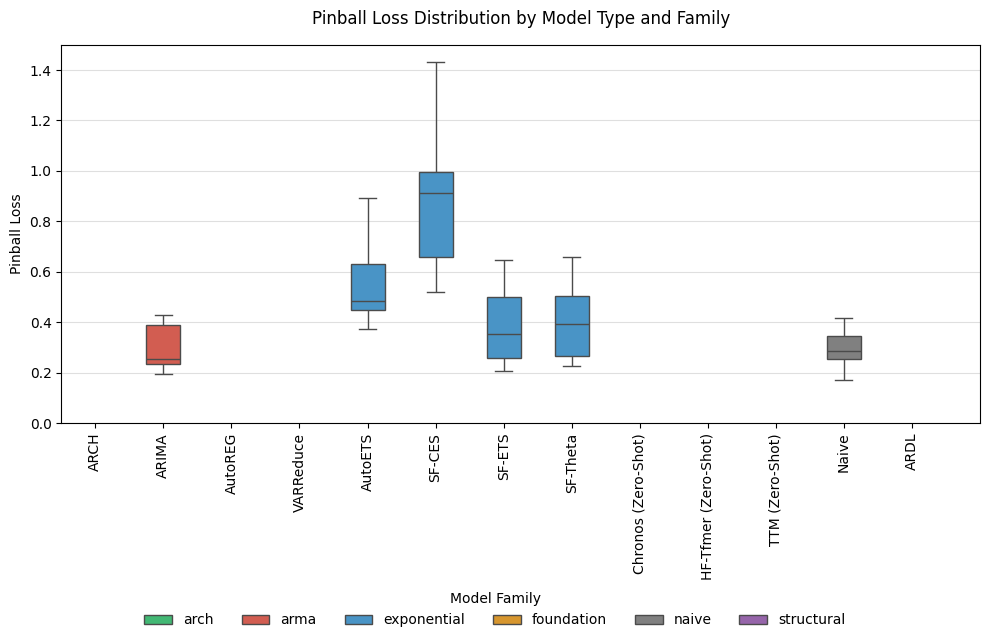

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette for model families
model_families = {
    "naive": "#808080",
    "arch": "#2ecc71",
    "arma": "#e74c3c",
    "exponential": "#3498db",
    "foundation": "#f39c12",
    "structural": "#9b59b6",
}

# Create the box plot
f, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis objects
sns.boxplot(
    data=best_results_pinball_flat,
    x="model_type",
    y="Best",
    hue="model_family",  # Assumes you have a model_family column
    width=0.5,
    palette=model_families,
    ax=ax,
)

# Add major grid lines (only horizontal)
ax.yaxis.grid(True, linestyle="-", which="major", color="grey", alpha=0.25)
# Remove vertical grid lines for better readability
ax.xaxis.grid(False)

# Reduce space between boxes by adjusting the plot limits
num_items = len(best_results_pinball_flat["model_type"].unique())
ax.set_xlim(-0.5, num_items)  # Adjust the x-axis limits
ax.set_ylim(0, 1.5)  # Adjust the y-axis limits
# Customize the plot
plt.title("Pinball Loss Distribution by Model Type and Family", fontsize=12, pad=15)
plt.xlabel("", fontsize=10)
plt.ylabel("Pinball Loss", fontsize=10)

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Move legend outside to the bottom and make it horizontal
legend = plt.legend(
    bbox_to_anchor=(0.5, 0.025),
    loc="upper center",
    title="Model Family",
    ncol=6,  # Set number of columns to match number of model families
    bbox_transform=plt.gcf().transFigure,
)

# Make the legend background transparent
legend.get_frame().set_alpha(0.0)


# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.savefig("pinball_boxplot.png", transparent=True, bbox_inches="tight", dpi=300)
plt.show()

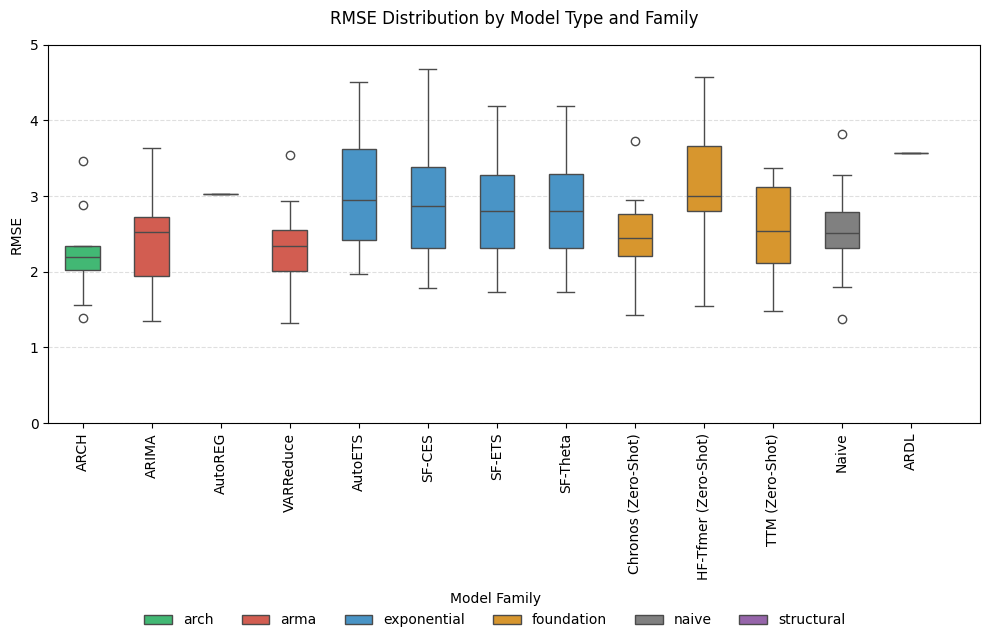

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette for model families
model_families = {
    "naive": "#808080",
    "arch": "#2ecc71",
    "arma": "#e74c3c",
    "exponential": "#3498db",
    "foundation": "#f39c12",
    "structural": "#9b59b6",
}

# Create the box plot
f, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis objects
# Make the figure and axes transparent
f.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

sns.boxplot(
    data=best_results_rmse_flat,
    x="model_type",
    y="Best",
    hue="model_family",  # Assumes you have a model_family column
    width=0.5,
    palette=model_families,
    ax=ax,
)

# Add major grid lines (only horizontal)
ax.yaxis.grid(True, linestyle="--", which="both", color="grey", alpha=0.25)
# Remove vertical grid lines for better readability
ax.xaxis.grid(False)

# Reduce space between boxes by adjusting the plot limits
num_items = len(best_results_rmse_flat["model_type"].unique())
ax.set_xlim(-0.5, num_items)  # Adjust the x-axis limits
ax.set_ylim(0, 5)  # Adjust the y-axis limits
# Customize the plot
plt.title("RMSE Distribution by Model Type and Family", fontsize=12, pad=15)
plt.xlabel("", fontsize=10)
plt.ylabel("RMSE", fontsize=10)

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Move legend outside to the bottom and make it horizontal
legend = plt.legend(
    bbox_to_anchor=(0.5, 0.025),
    loc="upper center",
    title="Model Family",
    ncol=6,  # Set number of columns to match number of model families
    bbox_transform=plt.gcf().transFigure,
)

# Make the legend background transparent
legend.get_frame().set_alpha(0.0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.savefig("rmse_boxplot.png", transparent=True, bbox_inches="tight", dpi=300)
plt.show()

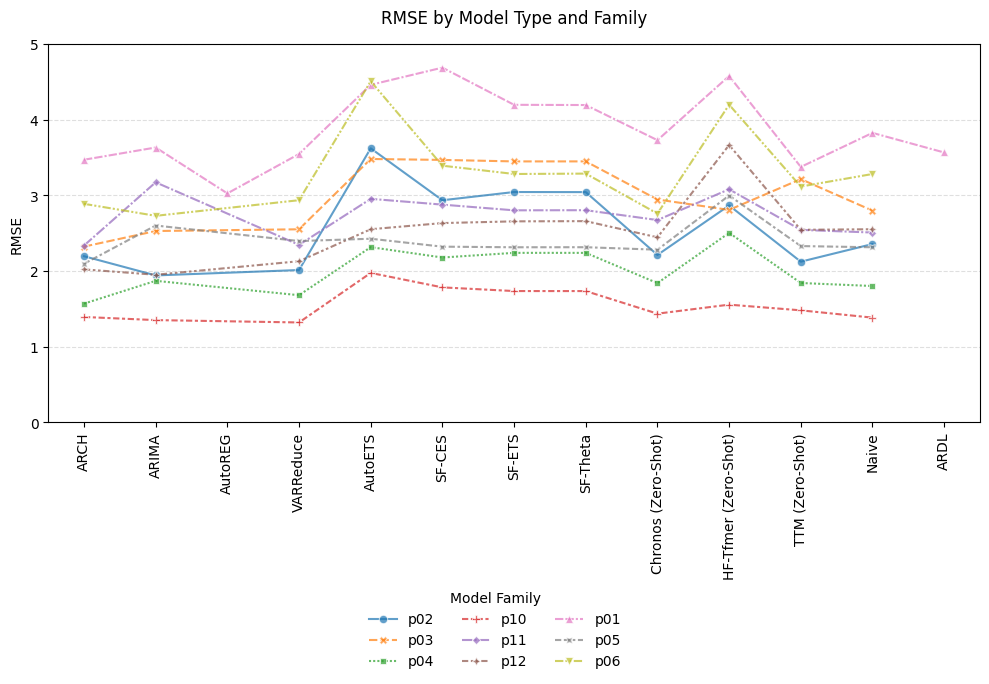

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the line plot
f, ax = plt.subplots(figsize=(10, 6))
# Make the figure and axes transparent
f.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)

# Create line plot
sns.lineplot(
    data=best_results_rmse_flat,
    x="model_type",
    y="Best",
    hue="validation_id",
    style="validation_id",  # Different line styles for different families
    markers=True,  # Add markers at data points
    alpha=0.7,  # Slightly transparent lines
    ax=ax,
)

# Add major grid lines
ax.yaxis.grid(True, linestyle="--", which="both", color="#808080", alpha=0.25)
ax.xaxis.grid(False)

# Adjust plot limits
num_items = len(best_results_rmse_flat["model_type"].unique())
ax.set_xlim(-0.5, num_items - 0.5)
ax.set_ylim(0, 5)

# Customize the plot
plt.title("RMSE by Model Type and Family", fontsize=12, pad=15)
plt.xlabel("", fontsize=10)
plt.ylabel("RMSE", fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=90)

# Move legend outside
legend = plt.legend(
    bbox_to_anchor=(0.5, 0.025),
    loc="upper center",
    title="Model Family",
    ncol=3,
    bbox_transform=plt.gcf().transFigure,
)

# Make legend transparent
legend.get_frame().set_alpha(0.0)

# Adjust layout
plt.tight_layout()

# Save and show the plot
plt.savefig("rmse_lineplot.png", transparent=True, bbox_inches="tight", dpi=300)
plt.show()